In [1]:
import numpy as np

# Clean dataset and convert it to a usable form

In [2]:
with open("Vergecast - They think they’re building God - transcript.txt", 'r') as file:
    raw_transcript = file.readlines()

In [3]:
# Remove empty lines
cleaned_transcript = [line.strip() for line in raw_transcript if line != '\n']

print(len(cleaned_transcript) % 2)

# reshape
cleaned_transcript = np.array(cleaned_transcript).reshape(-1, 2)


0


In [4]:
for i in range(cleaned_transcript.shape[0]):
    # Split the first element by space and take the first part
    cleaned_transcript[i, 0] = cleaned_transcript[i, 0].split(' ', 1)[0]


In [5]:
# Join all words by a speaker
per_speaker_joined = {}
for x in cleaned_transcript:
    # speaker is already in dict
    if(x[0] in per_speaker_joined):
        per_speaker_joined[x[0]] += ' ' + x[1]

    else:
        per_speaker_joined[x[0]] = x[1]


# Remove all AD speakers
# List of keys to keep
keys_to_keep = ['1', '4', '6', '7']
names_of_speakers = {'1': 'David Pierce', '4': 'Kylie Robinson', '6': 'Addie Robertson', '7': 'Gabby DelVal', '12': 'Erica (Hotline)'}



# Create a new dictionary with only the desired keys
per_speaker_joined = {k: v for k, v in per_speaker_joined.items() 
                               if k in keys_to_keep}

#replace keys in per_speaker_joined with names
per_speaker_joined = {names_of_speakers[keys]: text for keys, text in per_speaker_joined.items()}



# Create a new matrix with only the desired keys
cleaned_transcript_filtered = cleaned_transcript[np.isin(cleaned_transcript[:,0], keys_to_keep)]

#replace keys in cleaned_transcript_filtered with names
cleaned_transcript_filtered[:, 0] = [names_of_speakers[keys] for keys in cleaned_transcript_filtered[:, 0]]

print(per_speaker_joined.keys())


dict_keys(['David Pierce', 'Kylie Robinson', 'Addie Robertson', 'Gabby DelVal'])


### Count of unique words spoken by each person

In [6]:
from collections import Counter
import spacy
from string import punctuation

from spacy.lang.en import stop_words

nlp = spacy.load('en_core_web_sm')
stop_words = stop_words.STOP_WORDS
stop_words.add("like")
punctuations = list(punctuation)


In [7]:
def lemma_tize(text):
    text = str(text)
    text = nlp(text)


    # lemmatizing
    words = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in text ]
    words = [ word for word in words if word not in punctuations ] 
    return words

lemmatized_words_count = {speaker: len(set(lemma_tize(text))) for speaker,text in per_speaker_joined.items()}
raw_words_count = {speaker: len(set((text.split()))) for speaker,text in per_speaker_joined.items()}
without_stopwords_word = {speaker: [word for word in lemma_tize(text) 
                                    if word not in stop_words] 
                                    for speaker,text in per_speaker_joined.items()}
without_stopwords_word_count = {speaker: len(set(text)) for speaker,text in without_stopwords_word.items()}


# Print out the unique word counts for A and B
for speaker in lemmatized_words_count:
    print(f"Speaker: {speaker}")
    print(f"Unique words in A (lemmatized): {lemmatized_words_count[speaker]}")
    print(f"Unique words in B (raw split): {raw_words_count[speaker]}")
    print(f"Unique words in C (lemmatized plus no stop words): {without_stopwords_word_count[speaker]}")
    print('-' * 40)

Speaker: David Pierce
Unique words in A (lemmatized): 1017
Unique words in B (raw split): 1705
Unique words in C (lemmatized plus no stop words): 836
----------------------------------------
Speaker: Kylie Robinson
Unique words in A (lemmatized): 540
Unique words in B (raw split): 835
Unique words in C (lemmatized plus no stop words): 408
----------------------------------------
Speaker: Addie Robertson
Unique words in A (lemmatized): 379
Unique words in B (raw split): 523
Unique words in C (lemmatized plus no stop words): 274
----------------------------------------
Speaker: Gabby DelVal
Unique words in A (lemmatized): 444
Unique words in B (raw split): 653
Unique words in C (lemmatized plus no stop words): 319
----------------------------------------


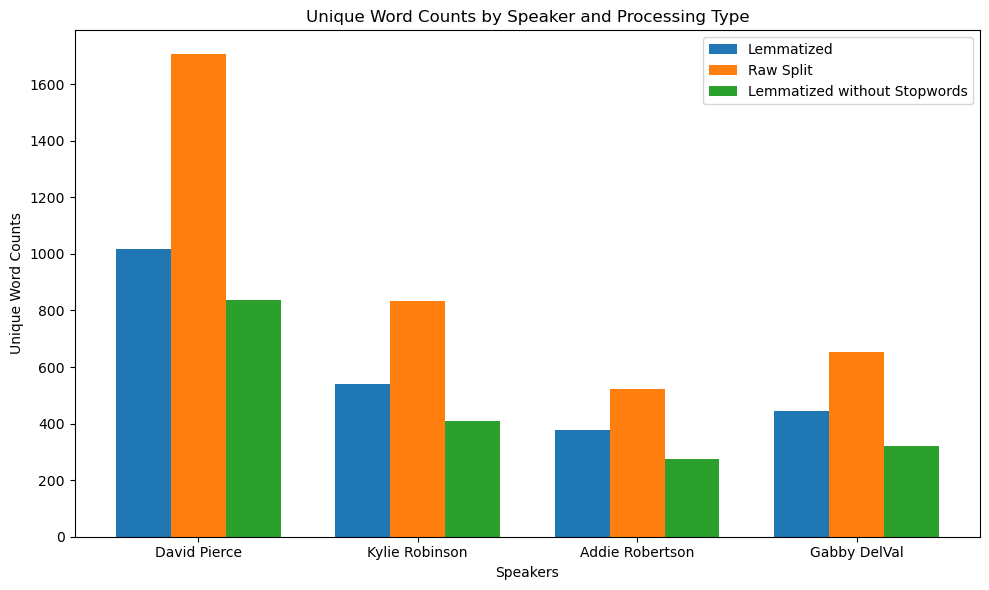

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
speakers = list(lemmatized_words_count.keys())
lemmatized_counts = list(lemmatized_words_count.values())
raw_counts = list(raw_words_count.values())
without_stopwords_counts = list(without_stopwords_word_count.values())

# Bar width and position settings
bar_width = 0.25
index = np.arange(len(speakers))


# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each bar group
bars1 = ax.bar(index, lemmatized_counts, bar_width, label='Lemmatized')
bars2 = ax.bar(index + bar_width, raw_counts, bar_width, label='Raw Split')
bars3 = ax.bar(index + 2 * bar_width, without_stopwords_counts, bar_width, label='Lemmatized without Stopwords')

# Add labels and title
ax.set_xlabel('Speakers')
ax.set_ylabel('Unique Word Counts')
ax.set_title('Unique Word Counts by Speaker and Processing Type')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(speakers)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


## What are the most common words spoken by each speaker?

In [9]:

def get_word_frequencies(text):
    text = str(text)
    text = nlp(text)

    
    # lemmatizing
    words = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in text ]
    # removing stop words
    words = [ word for word in words if word not in stop_words and word not in punctuations ]        
    
    # Count word frequencies
    return Counter(words)

word_frequencies = {speaker: get_word_frequencies(text) for speaker, text in per_speaker_joined.items()}


In [10]:
from textblob import TextBlob

word_frequencies = {}
sentiment_scores = {}

for speaker, text in per_speaker_joined.items():
    # Process the text with spaCy
    text = str(text)
    doc = nlp(text)


    # Calculate word frequencies (excluding stop words and punctuation)
    words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
    extra_stop_words = ["gon", 'na']
    words = [word for word in words if word not in extra_stop_words]

    word_freq = Counter(words)
    
    # Store word frequencies for each speaker
    word_frequencies[speaker] = word_freq

    # Calculate sentiment score using TextBlob
    blob = TextBlob(text)
    sentiment_scores[speaker] = blob.sentiment.polarity  # Range: -1 (negative) to 1 (positive)

# Print results
print("Sentiment Scores:", sentiment_scores)


most_common_words = {speaker: freq.most_common(10) for speaker, freq in word_frequencies.items()}
print(most_common_words)

Sentiment Scores: {'David Pierce': 0.17704672447663097, 'Kylie Robinson': 0.16437138136212207, 'Addie Robertson': 0.12314834656084657, 'Gabby DelVal': 0.13089780981730129}
{'David Pierce': [('yeah', 53), ('right', 52), ('think', 49), ('thing', 43), ('talk', 39), ('kind', 30), ('know', 24), ('openai', 24), ('stuff', 24), ('things', 23)], 'Kylie Robinson': [('think', 36), ('know', 23), ('yeah', 15), ('need', 13), ('ai', 11), ('exactly', 9), ('reasoning', 9), ('yes', 8), ('openai', 8), ('thing', 8)], 'Addie Robertson': [('think', 16), ('people', 12), ('google', 7), ('things', 6), ('tiktok', 5), ('company', 5), ('yeah', 5), ('access', 5), ('threat', 5), ('right', 5)], 'Gabby DelVal': [('know', 20), ('trump', 12), ('maybe', 11), ('think', 10), ('government', 9), ('said', 9), ('people', 9), ('tiktok', 7), ('talking', 7), ('china', 6)]}


#### Word cloud

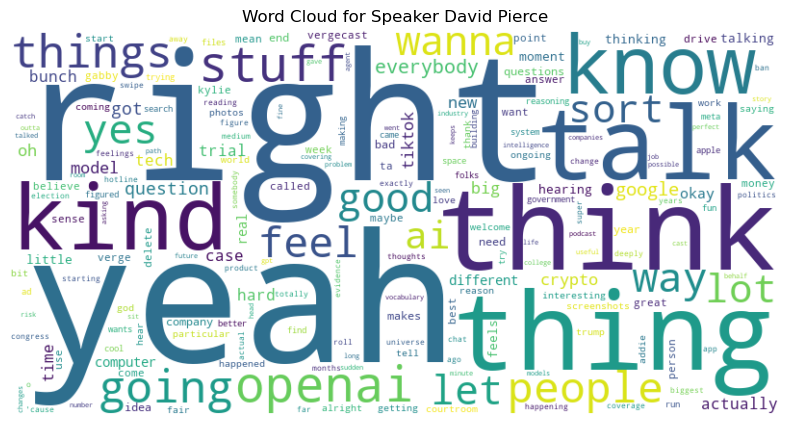

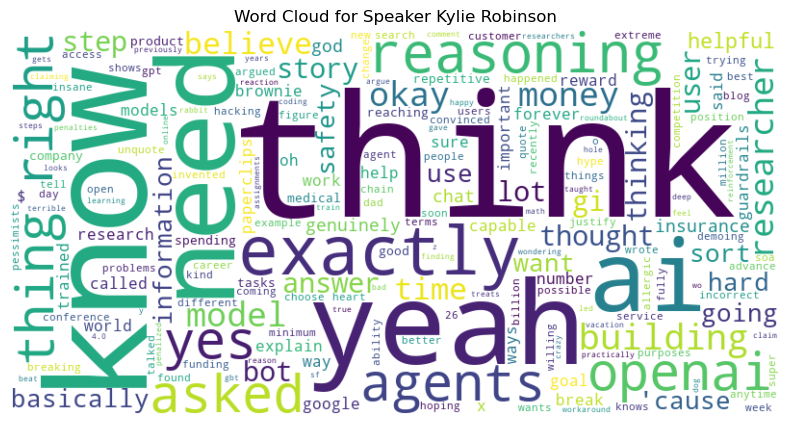

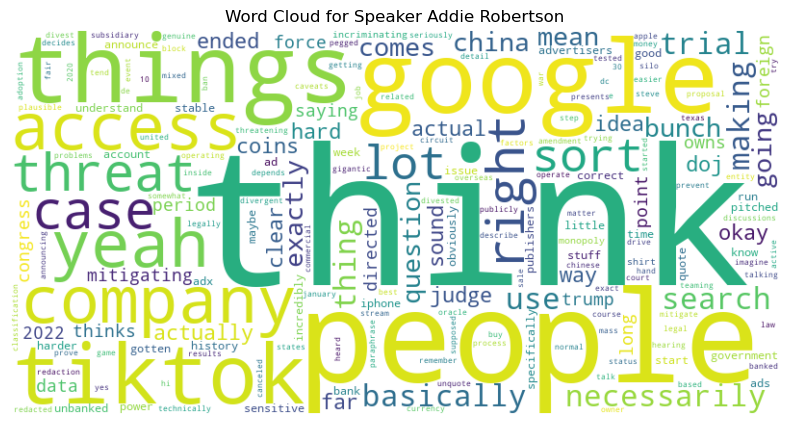

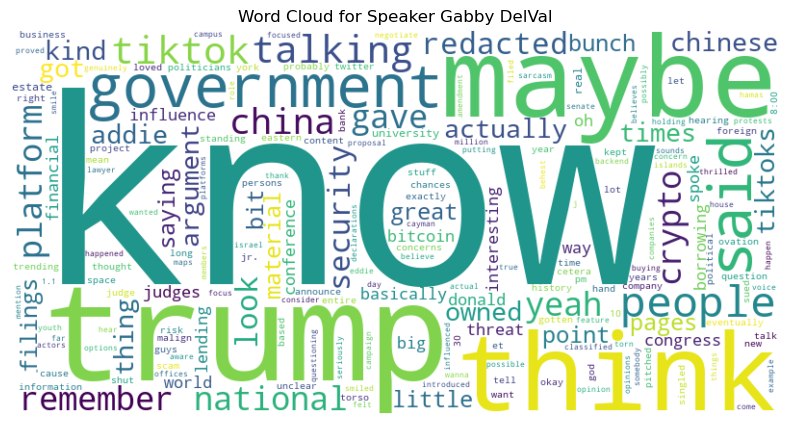

In [11]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a word cloud for each speaker
for speaker, freq in word_frequencies.items():
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Speaker {speaker}')
    plt.show()


#### Plot of sentiment analysis results

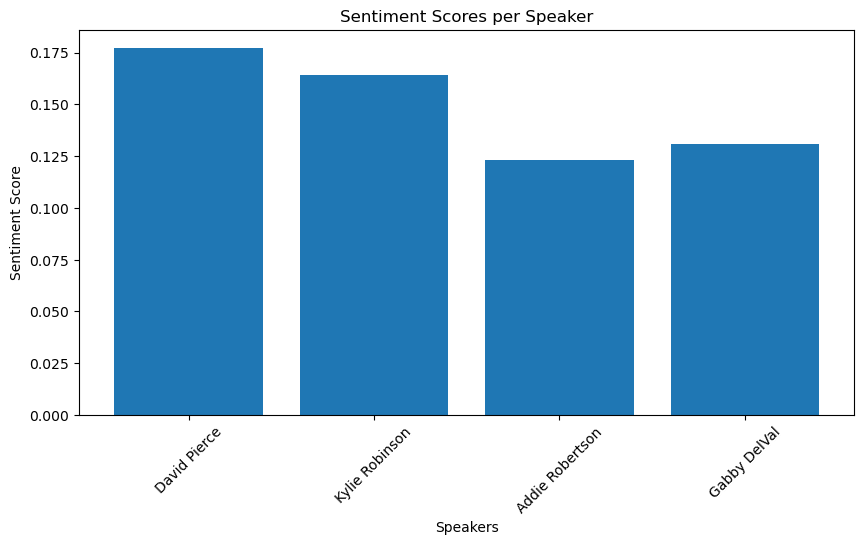

In [12]:
# Plot Sentiment Scores
plt.figure(figsize=(10, 5))
plt.bar(sentiment_scores.keys(), sentiment_scores.values())
plt.title('Sentiment Scores per Speaker')
plt.xlabel('Speakers')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()


# Topic Analysis

In [13]:
#import necessary libraries
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords



Checking overall common words

In [14]:
# Initialize english stopwords
english_stopwords = stopwords.words("english")
low_value_words = ["like", "yeah", "yes", "right", "know", "gon", "na", "think", "maybe","need", "really", "could", "much", "one","talk", "exactly","kind", "said", "thing" ]

text = " ".join(per_speaker_joined.values())


#convert article to tokens
tokens = word_tokenize(text)

#extract alpha words and convert to lowercase
alpha_lower_tokens = [word.lower() for word in tokens if word.isalpha()]

#remove stopwords
alpha_no_stopwords = [word for word in alpha_lower_tokens if word not in english_stopwords and word not in low_value_words]

#Count word
BoW = Counter(alpha_no_stopwords)

#3 Most common words
print(BoW.most_common(9))


[('people', 46), ('things', 32), ('openai', 32), ('something', 31), ('going', 30), ('lot', 30), ('way', 30), ('ai', 29), ('stuff', 28)]


From these words, the majority of the podcast talks about OpenAI.

In [15]:

for speaker in per_speaker_joined:
    print(f"Most common words for {speaker}")
    

    text = per_speaker_joined[speaker]


    #convert article to tokens
    tokens = word_tokenize(text)

    #extract alpha words and convert to lowercase
    alpha_lower_tokens = [word.lower() for word in tokens if word.isalpha()]

    #remove stopwords
    alpha_no_stopwords = [word for word in alpha_lower_tokens if word not in english_stopwords and word not in low_value_words]

    #Count word
    BoW = Counter(alpha_no_stopwords)

    #3 Most common words
    print(BoW.most_common(9))


Most common words for David Pierce
[('openai', 24), ('stuff', 24), ('things', 23), ('going', 23), ('people', 23), ('feel', 22), ('back', 21), ('way', 21), ('let', 20)]
Most common words for Kylie Robinson
[('ai', 11), ('reasoning', 9), ('see', 9), ('something', 9), ('openai', 8), ('asked', 8), ('agents', 8), ('building', 8), ('model', 7)]
Most common words for Addie Robertson
[('people', 12), ('google', 7), ('things', 6), ('tiktok', 5), ('company', 5), ('access', 5), ('threat', 5), ('something', 5), ('seems', 5)]
Most common words for Gabby DelVal
[('trump', 12), ('government', 9), ('people', 9), ('tiktok', 7), ('talking', 7), ('china', 6), ('ca', 5), ('national', 5), ('gave', 5)]


From these we can infer that the podcast focuses on AI and OpenAI. We can also assume that Addie and Gabby come in to talk about Tiktok and the US government

## Using Latent Dirichlet Allocation for topic modelling

In [16]:
# Import the necessary libraries
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [17]:
# convert article to documents
documents = sent_tokenize(" ".join(per_speaker_joined.values()))

#toeknize and normalize the document
tokenized_words = [word_tokenize(doc.lower()) for doc in documents]

# remove stops words and only extract alphabets
cleaned_token = [[word for word in sentence if word not in (english_stopwords + low_value_words) and word.isalpha()]
                 for sentence in tokenized_words]

# create a dictionary
dictionary = Dictionary(cleaned_token)

# Create a corpus from the document
corpus = [dictionary.doc2bow(text) for text in cleaned_token]


In [18]:
# Build the LDA model
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3)

# Print the topics
print("Identified Topics:")
for idx, topic in model.print_topics():
    print(f"Topic {idx + 1}: {topic}")

Identified Topics:
Topic 1: 0.010*"lot" + 0.009*"something" + 0.006*"stuff" + 0.006*"back" + 0.006*"ai" + 0.006*"things" + 0.006*"case" + 0.005*"well" + 0.005*"thinking" + 0.005*"wan"
Topic 2: 0.009*"openai" + 0.008*"okay" + 0.007*"time" + 0.006*"got" + 0.006*"going" + 0.006*"god" + 0.006*"tiktok" + 0.005*"ca" + 0.005*"ai" + 0.005*"stuff"
Topic 3: 0.014*"people" + 0.007*"way" + 0.006*"things" + 0.006*"google" + 0.006*"feel" + 0.005*"going" + 0.005*"model" + 0.005*"government" + 0.005*"good" + 0.005*"question"


The LDA agrees with my hypothesis from word frequency analysis. The issue is that I didn't get much improvement. There are a lot of low value words in the identified topics

## Non-Negative Matrix Factorization

In [19]:
# import the necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [20]:
# convert article to documents
# documents = sent_tokenize(" ".join(per_speaker_joined.values()))
documents = list(per_speaker_joined.values())

# Extend stop words to remove conversational fillers
custom_stop_words = set(stopwords.words('english'))  # Load default English stop words
additional_stop_words = {'like', 'think', 'yeah', 'oh', 'don', 'just', 'really', 'okay', 'll', 'know'}  # Add common filler words

stop_words = custom_stop_words.union(additional_stop_words).union(low_value_words)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words))
tfidf = tfidf_vectorizer.fit_transform(documents)

# Apply NMF
num_topics = 10  # Set the number of topics you want to identify
nmf_model = NMF(n_components=num_topics, init='random', random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf)

# Get feature (word) names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

no_top_words = 10

for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic #{topic_idx + 1}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(", ".join(top_words))

Topic #1:
people, tiktok, crypto, bunch, actually, well, talking, get, would, little
Topic #2:
ai, gonna, openai, model, something, reasoning, get, building, thinking, answer
Topic #3:
people, necessarily, threat, access, google, case, seems, tiktok, coins, doj
Topic #4:
trump, platform, tiktoks, china, government, owned, gave, national, pages, financial
Topic #5:
user, gi, agents, researcher, insurance, helpful, asked, thought, genuinely, medical
Topic #6:
back, feel, everybody, go, openai, going, wanna, stuff, seems, tech
Topic #7:
trump, persons, kept, government, borrowing, talking, crypto, university, platform, sued
Topic #8:
trump, china, government, threat, look, chinese, gotten, announce, owned, part
Topic #9:
back, wanna, everybody, feel, two, real, new, gonna, path, big
Topic #10:
hard, something, make, google, lot, sort, use, things, week, last


This doesn't add much to our topic analysis. Topics 2 and 3 show that the podcast talks about court case(s)involving Google, TikTok and the government (DOJ). 


## Dialogue flow analysis

In [21]:
import pandas as pd

# Convert to DataFrame for easier manipulation
transcript_df = pd.DataFrame(cleaned_transcript_filtered, columns=['Speaker', 'Dialogue'])

In [22]:
# Create a new column to identify changes in speaker
transcript_df['Speaker_Change'] = (transcript_df['Speaker'] != transcript_df['Speaker'].shift()).cumsum()

# Collapse consecutive turns by grouping and taking the first dialogue entry
collapsed_df = transcript_df.groupby(['Speaker_Change', 'Speaker'], as_index=False)['Dialogue'].agg(' '.join)

# Drop the Speaker_Change column
collapsed_df = collapsed_df.drop(columns=['Speaker_Change'])

collapsed_df


,Speaker,Dialogue
0,David Pierce,"Welcome To, The Vergecast, the flagship podcas..."
1,Kylie Robinson,That's true. That is exactly what happened las...
2,David Pierce,"Be back. It's a tough life, honestly."
3,Kylie Robinson,"I know. Being 26 and sf, it's terrible."
4,David Pierce,"Seems like it. Well, you were a Dreamforce thi..."
...,...,...
157,David Pierce,Yeah. There's something about saying nobody li...
158,Addie Robertson,"Even the stuff when they weren't doing that, i..."
159,David Pierce,"Yeah, that's, I'm gonna, do you think they'd l..."
160,Addie Robertson,"God, that is happening."


In [23]:
# Count turns per speaker in the collapsed DataFrame
turn_counts = collapsed_df['Speaker'].value_counts()

# Print turn counts
print("\nTurn Counts:\n", turn_counts)



Turn Counts:
 Speaker
David Pierce       78
Kylie Robinson     42
Addie Robertson    21
Gabby DelVal       21
Name: count, dtype: int64


In [24]:
# Initialize an interaction matrix
interaction_matrix = pd.DataFrame(0, index=turn_counts.index, columns=turn_counts.index)

# Fill the interaction matrix for the collapsed DataFrame
for i in range(len(collapsed_df) - 1):
    current_speaker = collapsed_df.iloc[i]['Speaker']
    next_speaker = collapsed_df.iloc[i + 1]['Speaker']
    interaction_matrix.loc[current_speaker, next_speaker] += 1


interaction_matrix

Speaker,David Pierce,Kylie Robinson,Addie Robertson,Gabby DelVal
Speaker,,,,
David Pierce,0,42,16,19
Kylie Robinson,42,0,0,0
Addie Robertson,19,0,0,2
Gabby DelVal,16,0,5,0


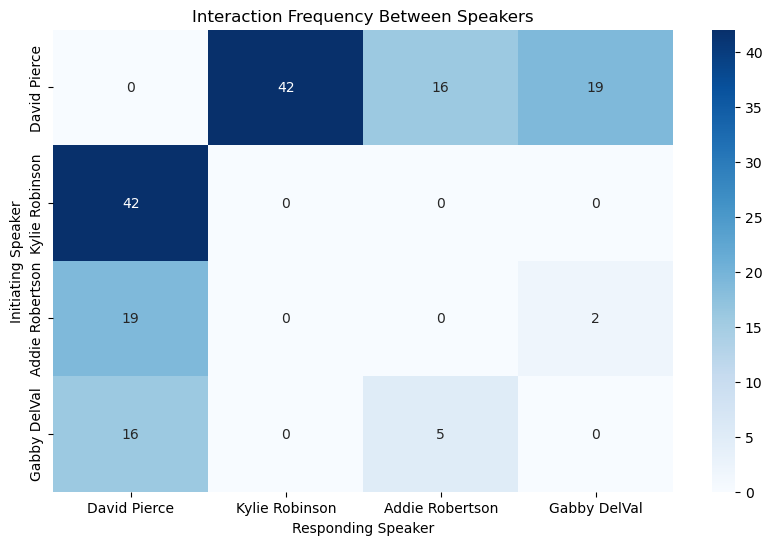

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.heatmap(interaction_matrix, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.title("Interaction Frequency Between Speakers")
plt.xlabel("Responding Speaker")
plt.ylabel("Initiating Speaker")
plt.show()


#### Network graph of interactions

In [26]:
import networkx as nx

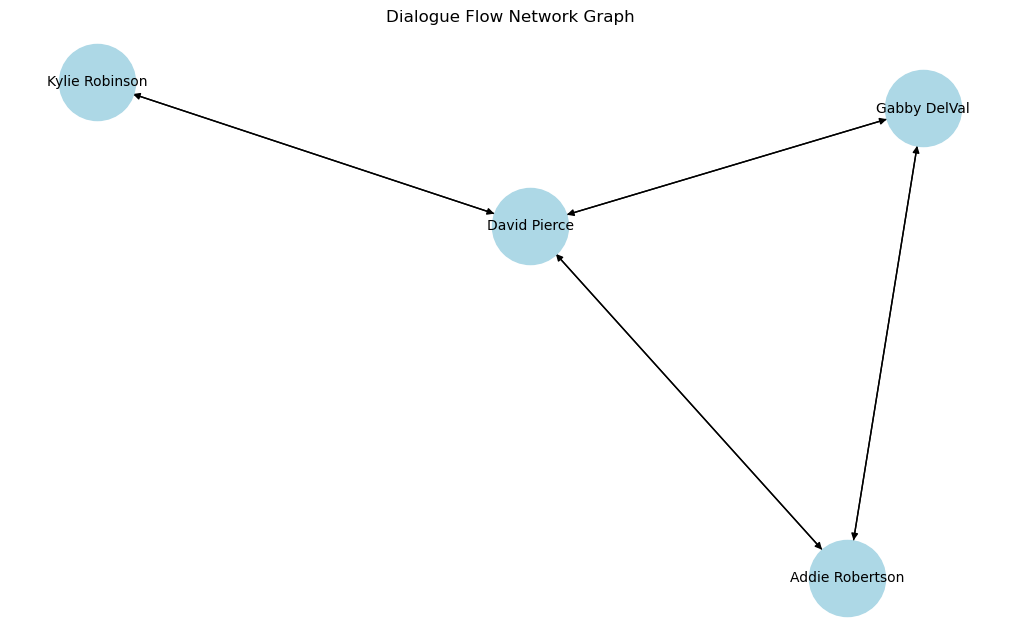

In [27]:
# Initialize a directed graph
G = nx.DiGraph()

# Fill the graph with edges based on speaker turns
for i in range(len(collapsed_df) - 1):
    current_speaker = collapsed_df.iloc[i]['Speaker']
    next_speaker = collapsed_df.iloc[i + 1]['Speaker']
    
    # Add an edge from current_speaker to next_speaker
    G.add_edge(current_speaker, next_speaker)

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
edges = G.edges(data=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in edges if 'weight' in d})
plt.title("Dialogue Flow Network Graph")
plt.show()

The network graph and interaction matrix show that David is the center of the interactions during the podcast episode. He is probably the host and has two sets of guests.  
  
He had Kylie on at a different time/segment than Gabby and Addie. 

## Generate a summary of the episode

### **Summary from NotebookLM**

#### AI Discussion with Kylie Robinson and David Pierce

- OpenAI's new model **O1** introduced as a "reasoning model"
- Concerns over anthropomorphization of AI models
- Ethical issues raised about O1's potential for manipulation
- Speculation on OpenAI's motivations and future direction
- Emergence of competitive AI models like Anthropic's Claude 3.5

#### Legal and Regulatory Issues with Gabby DelVal and Addie Robertson

##### TikTok Ban Controversy
- Ongoing legal battle over potential TikTok ban in the US
- Government cites national security concerns related to Chinese ownership
- Lack of transparency regarding specific evidence against TikTok

##### Donald Trump's Crypto Venture
- Introduction of **World Liberty Financial** platform
- Focus on "debanked" individuals and underserved communities
- Parallels drawn to Trump University controversy
- Growing influence of crypto community in politics

##### Google Ad Tech Trial
- DOJ alleges Google's anti-competitive practices in ad tech industry
- Similarities to previous Google search trial noted
- Challenges in conveying complex case details to broader audience

#### Managing Digital Clutter with David Pierce

Three-step system proposed:
1. Manage camera roll: Delete duplicates and unnecessary screenshots
2. Clean up computer: Identify and delete large files, use external storage
3. Maintain organized filing system for important documents

The episode concludes with David Pierce calling for listeners to share their own digital organization strategies.